In [305]:
import pandas as pd
import numpy as np

import requests

import os
import time
from datetime import datetime
import sys
import yaml
import gc


from data_loader import *
from utils import *
from nn import *


import seaborn as sns
sns.set_style("darkgrid")
plt.rcParams.update({
    'axes.facecolor': '#1e1e1e',
    'figure.facecolor': '#1e1e1e',
    'axes.edgecolor': 'white',
    'axes.labelcolor': 'white',
    'xtick.color': 'white',
    'ytick.color': 'white',
    'text.color': 'white',
    'axes.grid': True,
    'grid.color': 'gray'
})

pd.set_option("display.max_column",None)
print(os.getcwd())


%load_ext autoreload
%reload_ext autoreload
%autoreload 2


def auto_reload():
    %load_ext autoreload
    %reload_ext autoreload
    %autoreload 2

/Users/echhitjoshi/Library/Mobile Documents/com~apple~CloudDocs/Work/overperformXG/app
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [251]:
with open("config.yaml",'r') as f:
    config = yaml.safe_load(f)

home_dir = config['HOME_DIRECTORY']
home_dir

'/Users/echhitjoshi/Library/Mobile Documents/com~apple~CloudDocs/Work/overperformXG'

In [143]:
# Model File Configs:
# Every Run of the notebook is logged in to a submodel folder for it

############################################################################
# Please set output path to the project directory where it is uncompressed #
############################################################################

project_path = home_dir + "/outputs/models/"




output_path = ""

submodel_name = ""

encoding_path = ""
feature_report_path = ""
def create_submodel(model_name:str):
    author = "EJ"
    global submodel_name
    submodel_name = datetime.now().strftime("%d_%H_%M") + "_"+model_name
    global output_path
    output_path = project_path+submodel_name
    global encoding_path
    encoding_path = output_path+"/encodings/"
    global feature_report_path
    feature_report_path = output_path+"/feature_report/"
    os.mkdir(output_path)
    os.mkdir(encoding_path)
    os.mkdir(feature_report_path)


In [144]:
create_submodel("test")

# API Football:
https://www.api-football.com

![PYTHON LOGO](https://www.api-football.com/public/img/news/archi-beta.jpg)

In [11]:
leagues_dat = get_leagues(home_dir +"/data/Leagues/leagues.parquet")
leagues_dat[['league_id','league_name','country_name']]

,league_id,league_name,country_name
0,4,Euro Championship,World
1,21,Confederations Cup,World
2,61,Ligue 1,France
3,144,Jupiler Pro League,Belgium
4,71,Serie A,Brazil
...,...,...,...
1128,1131,Super Cup,Mongolia
1129,1132,AFC Challenge League,World
1130,1133,Goiano - 3,Brazil
1131,1001,CONCACAF Women U20,World


# Leagues subset:

In [12]:
# Configs
major_leagues = ["Premier League","La Liga","Serie A","Bundesliga","Eredivisie","Ligue 1"]
major_countries = ["England","Spain","Italy","Germany","Netherlands","France","Brazil"]
teams = ["Liverpool","Wolves"] # teams to pull players data of
seasons = [2022,2021,2023,2024] # seasons to pull players and teams stats of



leagues_subset = leagues_dat[leagues_dat.league_name.isin(major_leagues) & leagues_dat.country_name.isin(major_countries)] # league ID to pull from, current values: {39:premier league}, Add to dictionary as needed

In [13]:
leagues_subset

,seasons,league_id,league_name,league_type,league_logo,country_name,country_code,country_flag
2,"[{'coverage': {'fixtures': {'events': True, 'l...",61,Ligue 1,League,https://media.api-sports.io/football/leagues/6...,France,FR,https://media.api-sports.io/flags/fr.svg
4,"[{'coverage': {'fixtures': {'events': True, 'l...",71,Serie A,League,https://media.api-sports.io/football/leagues/7...,Brazil,BR,https://media.api-sports.io/flags/br.svg
5,"[{'coverage': {'fixtures': {'events': True, 'l...",39,Premier League,League,https://media.api-sports.io/football/leagues/3...,England,GB,https://media.api-sports.io/flags/gb.svg
6,"[{'coverage': {'fixtures': {'events': True, 'l...",78,Bundesliga,League,https://media.api-sports.io/football/leagues/7...,Germany,DE,https://media.api-sports.io/flags/de.svg
7,"[{'coverage': {'fixtures': {'events': True, 'l...",135,Serie A,League,https://media.api-sports.io/football/leagues/1...,Italy,IT,https://media.api-sports.io/flags/it.svg
8,"[{'coverage': {'fixtures': {'events': True, 'l...",88,Eredivisie,League,https://media.api-sports.io/football/leagues/8...,Netherlands,NL,https://media.api-sports.io/flags/nl.svg
10,"[{'coverage': {'fixtures': {'events': True, 'l...",140,La Liga,League,https://media.api-sports.io/football/leagues/1...,Spain,ES,https://media.api-sports.io/flags/es.svg


# Read All fixtures data

In [ ]:
fixtures_dir = home_dir + "/data/Fixtures"

complete_data = pd.DataFrame()
for file in os.listdir(fixtures_dir):    
    dat = pd.read_parquet(os.path.join(fixtures_dir,file))
    complete_data = pd.concat([complete_data,dat],axis = 0)

complete_data = complete_data.reset_index()
complete_data.drop(columns = ['index'],inplace=True)

/var/folders/x2/4jp5z9p56hd1r0cvzk8fb0200000gn/T/ipykernel_20674/3479433963.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  complete_data = pd.concat([complete_data,dat],axis = 0)


In [248]:
# Data checks
complete_data['passes_accuracy'] = complete_data['passes_accuracy'].astype("float64")

# Targets
complete_data['outcome_num'] = pd.Categorical(complete_data.outcome).codes

complete_data['win'] = np.where(complete_data.outcome.str.lower() == 'win', 1,0)


In [ ]:
# This is the dictionary that contains all information about the features    
dat_dict = find_data_types(complete_data,config['OUTCOME_COLS'] + ['outcome_num','outcome'])
dat_dict = pd.DataFrame(list(dat_dict.items()),columns =['feature','type'])

# differentiate modeling features
non_modeling_features = config['FIXTURE_COLS'] + config['OUTCOME_COLS'] + config['MISC_COLS'] + ['outcome_num']
dat_dict['modeling_feature'] = np.where(dat_dict['feature'].isin(non_modeling_features),0,1)
dat_dict['encoded'] = 0

print(dat_dict['type'].value_counts())
dat_dict.reset_index(drop= True)
dat_dict

type
numeric        35
target         10
categorical     4
other           2
Name: count, dtype: int64


,feature,type,modeling_feature,encoded
0,player_id,numeric,0,0
1,player_name,categorical,0,0
2,offsides,numeric,1,0
3,games_minutes,numeric,0,0
4,games_number,numeric,0,0
5,games_position,categorical,0,0
6,games_rating,categorical,0,0
7,games_captain,other,0,0
8,games_substitute,other,0,0
9,shots_total,numeric,1,0


In [146]:
## Encode Features
dat_dict = create_data_index(complete_data,dat_dict,'target',encoding_path)
dat_dict

,feature,type,modeling_feature,encoded
0,player_id,numeric,0,0
1,player_name,categorical,0,0
2,offsides,numeric,1,0
3,games_minutes,numeric,0,0
4,games_number,numeric,0,0
5,games_position,categorical,0,0
6,games_rating,categorical,0,0
7,games_captain,other,0,0
8,games_substitute,other,0,0
9,shots_total,numeric,1,0


In [37]:
# quick knn clustering
from sklearn.cluster import KMeans

# who is ekitike most similar to 

stiker_stats = complete_data[['games_position','player_name'] + attacking_stat_cols].fillna(0)[complete_data[['games_position','player_name'] + attacking_stat_cols].fillna(0).games_position.isin(['F'])].groupby(['player_name']).agg(n_games = ('player_name','size'),
                                                                          avg_dribble_success = ('dribble_success_rate','mean'),
                                                                          std_dribble_success = ('dribble_success_rate','std'),
                                                                          avg_target_shot_cr = ('target_shot_conversion_perc','mean'),
                                                                          std_target_shot_cr = ('target_shot_conversion_perc','std'),
                                                                          avg_duels_cr = ('duels_won_perc','mean'),
                                                                          std_duels_cr = ('duels_won_perc','std'),
                                                                          avg_pass_accuracy = ('pass_accuracy_perc','mean'),
                                                                          std_pass_accuracy = ('pass_accuracy_perc','std')
                                                                          )


In [38]:
stiker_stats = stiker_stats[stiker_stats.n_games > 30]
stiker_stats.shape

(72, 9)

In [39]:
stiker_stats

,n_games,avg_dribble_success,std_dribble_success,avg_target_shot_cr,std_target_shot_cr,avg_duels_cr,std_duels_cr,avg_pass_accuracy,std_pass_accuracy
player_name,,,,,,,,,
Alexander Isak,65,41.008547,37.573602,37.512821,42.151474,33.051244,20.340532,77.344333,12.969312
Alexander Sørloth,35,29.897959,36.658585,37.619048,44.527816,38.938755,22.737437,73.482921,20.004458
Amine Adli,48,29.166667,40.168087,9.027778,26.174161,41.428933,29.799117,72.008091,29.411591
Anthony Elanga,34,17.401961,28.156582,8.333333,25.375961,36.129255,26.356935,73.283469,14.944216
Anthony Gordon,67,37.777778,35.678417,20.398010,37.808317,50.394848,19.133019,81.521477,9.556990
...,...,...,...,...,...,...,...,...,...
Victor Okoh Boniface,47,40.937183,36.607344,24.113475,34.369495,37.658297,24.843878,64.328153,27.281410
Vinícius Júnior,50,34.972572,26.081252,25.666667,37.865378,40.989220,22.259735,73.059472,20.954705
William Osula,38,6.140351,23.061822,2.631579,16.222142,12.719298,26.404741,13.157895,30.303246


In [40]:
stiker_stats.sort_values('avg_dribble_success',ascending=False)

,n_games,avg_dribble_success,std_dribble_success,avg_target_shot_cr,std_target_shot_cr,avg_duels_cr,std_duels_cr,avg_pass_accuracy,std_pass_accuracy
player_name,,,,,,,,,
Lionel Messi,31,58.882488,23.355850,29.946237,37.343461,49.335136,16.274889,82.696262,4.495736
Florian Wirtz,49,50.046603,23.052184,23.469388,38.477742,42.927937,13.997218,83.161487,6.186007
Lamine Yamal,44,45.591956,35.159846,11.363636,32.103822,56.314001,20.889237,81.271598,16.192860
Ousmane Dembélé,52,43.978938,34.511310,22.724359,37.872376,41.541989,29.341890,76.560464,20.068806
Luis Díaz,62,43.840246,37.042307,13.682796,29.815976,34.078314,19.292201,79.652949,20.627622
...,...,...,...,...,...,...,...,...,...
Sam Greenwood,33,6.060606,24.230584,3.030303,17.407766,16.717172,29.792351,25.123256,36.085344
Youssef Chermiti,50,5.000000,20.824828,0.000000,0.000000,12.758333,22.141079,20.996970,35.362429
Ben Brereton Díaz,31,4.838710,15.026858,0.000000,0.000000,20.349462,31.033577,43.077812,40.472550


In [42]:
# among 18 players, size 3 uniform clusters
km = KMeans(10,random_state= 5)
stiker_stats['cluster_dribble'] = km.fit_predict(stiker_stats[['avg_dribble_success']])

km = KMeans(10,random_state= 5)
stiker_stats['cluster_shot_cr'] = km.fit_predict(stiker_stats[['avg_target_shot_cr']])

km = KMeans(10,random_state= 5)
stiker_stats['cluster_duels'] = km.fit_predict(stiker_stats[['avg_duels_cr']])

km = KMeans(10,random_state= 5)
stiker_stats['cluster_pass'] = km.fit_predict(stiker_stats[['avg_pass_accuracy']])

In [44]:
# check by clusters:
stiker_stats.sort_values(["avg_target_shot_cr","cluster_shot_cr"],ascending= [0,0])[["avg_target_shot_cr","std_target_shot_cr","cluster_shot_cr"]].head(10)

,avg_target_shot_cr,std_target_shot_cr,cluster_shot_cr
player_name,,,
Artem Dovbyk,39.120370,46.025331,8
Alexander Sørloth,37.619048,44.527816,8
Alexander Isak,37.512821,42.151474,8
Robert Lewandowski,35.727700,42.194497,0
Chris Wood,34.701493,44.890369,0
Dominic Solanke,34.649123,44.751831,0
Erling Haaland,34.337798,38.934577,0
Kylian Mbappé,34.098639,36.055646,0
Kai Havertz,31.818182,41.113756,6


In [49]:
stiker_stats.sort_values(["avg_dribble_success","cluster_dribble"],ascending= [0,0])[["avg_dribble_success","std_dribble_success","cluster_dribble"]].head(10)

,avg_dribble_success,std_dribble_success,cluster_dribble
player_name,,,
Lionel Messi,58.882488,23.355850,5
Florian Wirtz,50.046603,23.052184,3
Lamine Yamal,45.591956,35.159846,3
Ousmane Dembélé,43.978938,34.511310,7
Luis Díaz,43.840246,37.042307,7
Bukayo Saka,43.764791,34.560404,7
Benjamin Šeško,43.448118,35.289555,7
Gerard Moreno,43.066239,39.105449,7
Leandro Trossard,42.593897,43.095167,7


In [50]:
stiker_stats.sort_values(["avg_duels_cr","cluster_duels"],ascending= [0,0])[["avg_duels_cr","std_duels_cr","cluster_duels"]].head(10)

,avg_duels_cr,std_duels_cr,cluster_duels
player_name,,,
Lamine Yamal,56.314001,20.889237,3
Thierno Barry,54.228578,18.863703,3
Anthony Gordon,50.394848,19.133019,3
Benjamin Šeško,49.744306,20.755658,3
Juanmi Latasa,49.716603,27.856468,3
Evanilson,49.592597,22.604833,3
Lionel Messi,49.335136,16.274889,3
Bukayo Saka,49.098078,18.662694,3
Loïs Openda,47.577957,17.844568,6


In [76]:
complete_data.columns

Index(['player_id', 'player_name', 'offsides', 'games_minutes', 'games_number',
       'games_position', 'games_rating', 'games_captain', 'games_substitute',
       'shots_total', 'shots_on', 'goals_total', 'goals_conceded',
       'goals_assists', 'goals_saves', 'passes_total', 'passes_key',
       'passes_accuracy', 'tackles_total', 'tackles_blocks',
       'tackles_interceptions', 'duels_total', 'duels_won',
       'dribbles_attempts', 'dribbles_success', 'dribbles_past', 'fouls_drawn',
       'fouls_committed', 'cards_yellow', 'cards_red', 'penalty_won',
       'penalty_commited', 'penalty_scored', 'penalty_missed', 'penalty_saved',
       'fixture_id', 'team_goals_scored', 'team_non_penalty_goals_scored',
       'team_goals_scored_half', 'team_goals_conceded',
       'team_non_penalty_goals_conceded', 'team_goals_conceded_half',
       'opponent', 'team_winner', 'team', 'outcome', 'dribble_success_rate',
       'target_shot_conversion_perc', 'duels_won_perc', 'pass_accuracy_perc']

/var/folders/x2/4jp5z9p56hd1r0cvzk8fb0200000gn/T/ipykernel_20674/3297584559.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


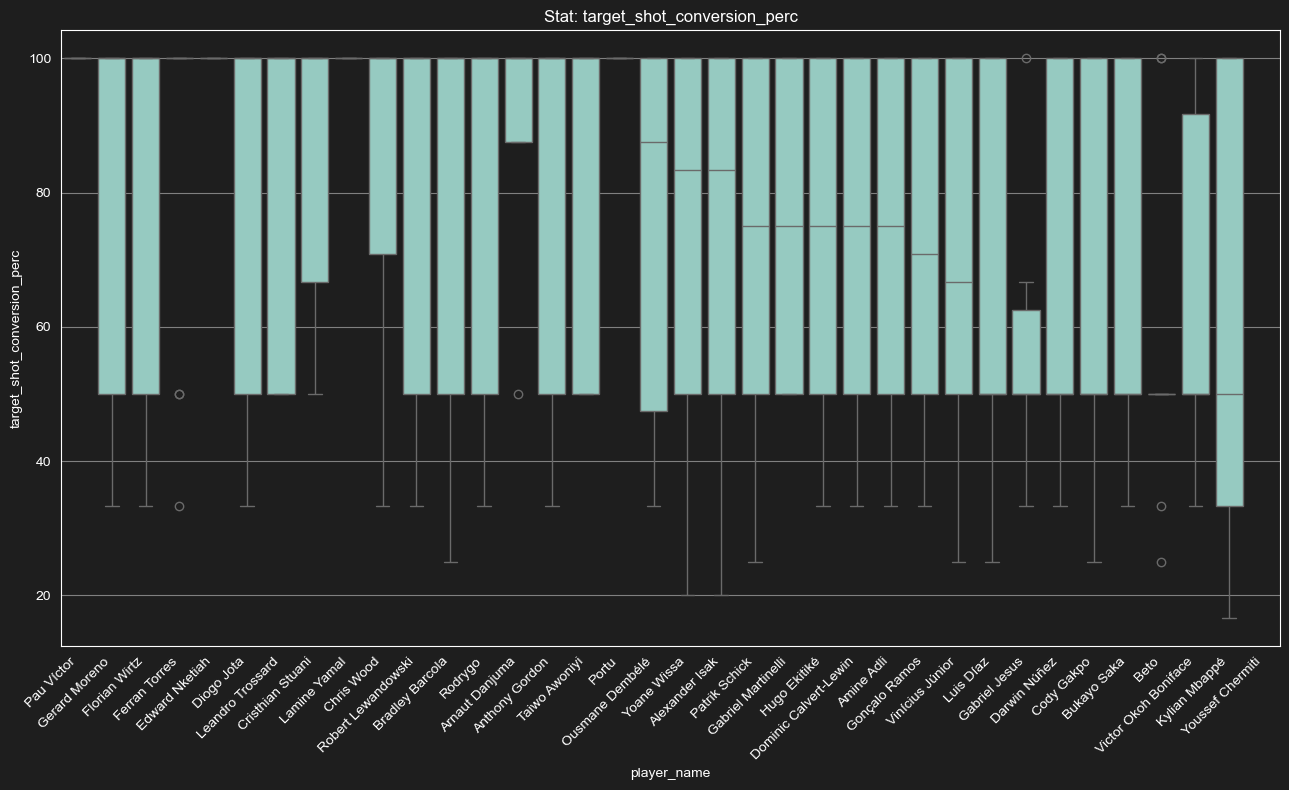

In [ ]:
filter_query = 'games_position.isin(["F"])'


# Stat to look at:
stat = 'target_shot_conversion_perc'

# configs 
min_appearance = 40

dribble_dat_g = complete_data[complete_data.games_position.isin(['F'])].reset_index().groupby("player_name").agg(n_apps = ("player_name","size"),stat = (stat,"median")).reset_index()
dribble_dat_g = dribble_dat_g[dribble_dat_g.n_apps >= min_appearance]
dribble_dat_g['rank'] = dribble_dat_g["stat"].fillna(0).rank(ascending= False,method = 'dense')
dribble_dat_g.sort_values("rank",inplace = True)

fig, ax = plt.subplots(figsize=(13, 8))

# Plot correctly, no comma here
sns.boxplot(
    data=dribble_dat[dribble_dat.player_name.isin(dribble_dat_g[dribble_dat_g['rank'] < 15]['player_name'])],
    x="player_name",
    y=stat,
    order=dribble_dat_g[dribble_dat_g['rank'] < 15]['player_name'],
    ax=ax,
    
)

# Now this works correctly on `ax`
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title(f"Stat: {stat}")
plt.tight_layout()
plt.show()


In [ ]:
complete_data[['outcome_num','outcome']].value_counts()

outcome_num  outcome
2            win        0.469357
1            loss       0.290703
0            draw       0.239940
Name: proportion, dtype: float64

[Text(0.5, 0, 'offsides'),
 Text(1.5, 0, 'shots_total'),
 Text(2.5, 0, 'shots_on'),
 Text(3.5, 0, 'goals_total'),
 Text(4.5, 0, 'goals_assists'),
 Text(5.5, 0, 'duels_total'),
 Text(6.5, 0, 'duels_won'),
 Text(7.5, 0, 'dribbles_attempts'),
 Text(8.5, 0, 'dribbles_success'),
 Text(9.5, 0, 'fouls_drawn'),
 Text(10.5, 0, 'penalty_won'),
 Text(11.5, 0, 'dribble_success_rate'),
 Text(12.5, 0, 'target_shot_conversion_perc'),
 Text(13.5, 0, 'duels_won_perc'),
 Text(14.5, 0, 'team_goals_scored'),
 Text(15.5, 0, 'team_non_penalty_goals_scored'),
 Text(16.5, 0, 'team_goals_conceded')]

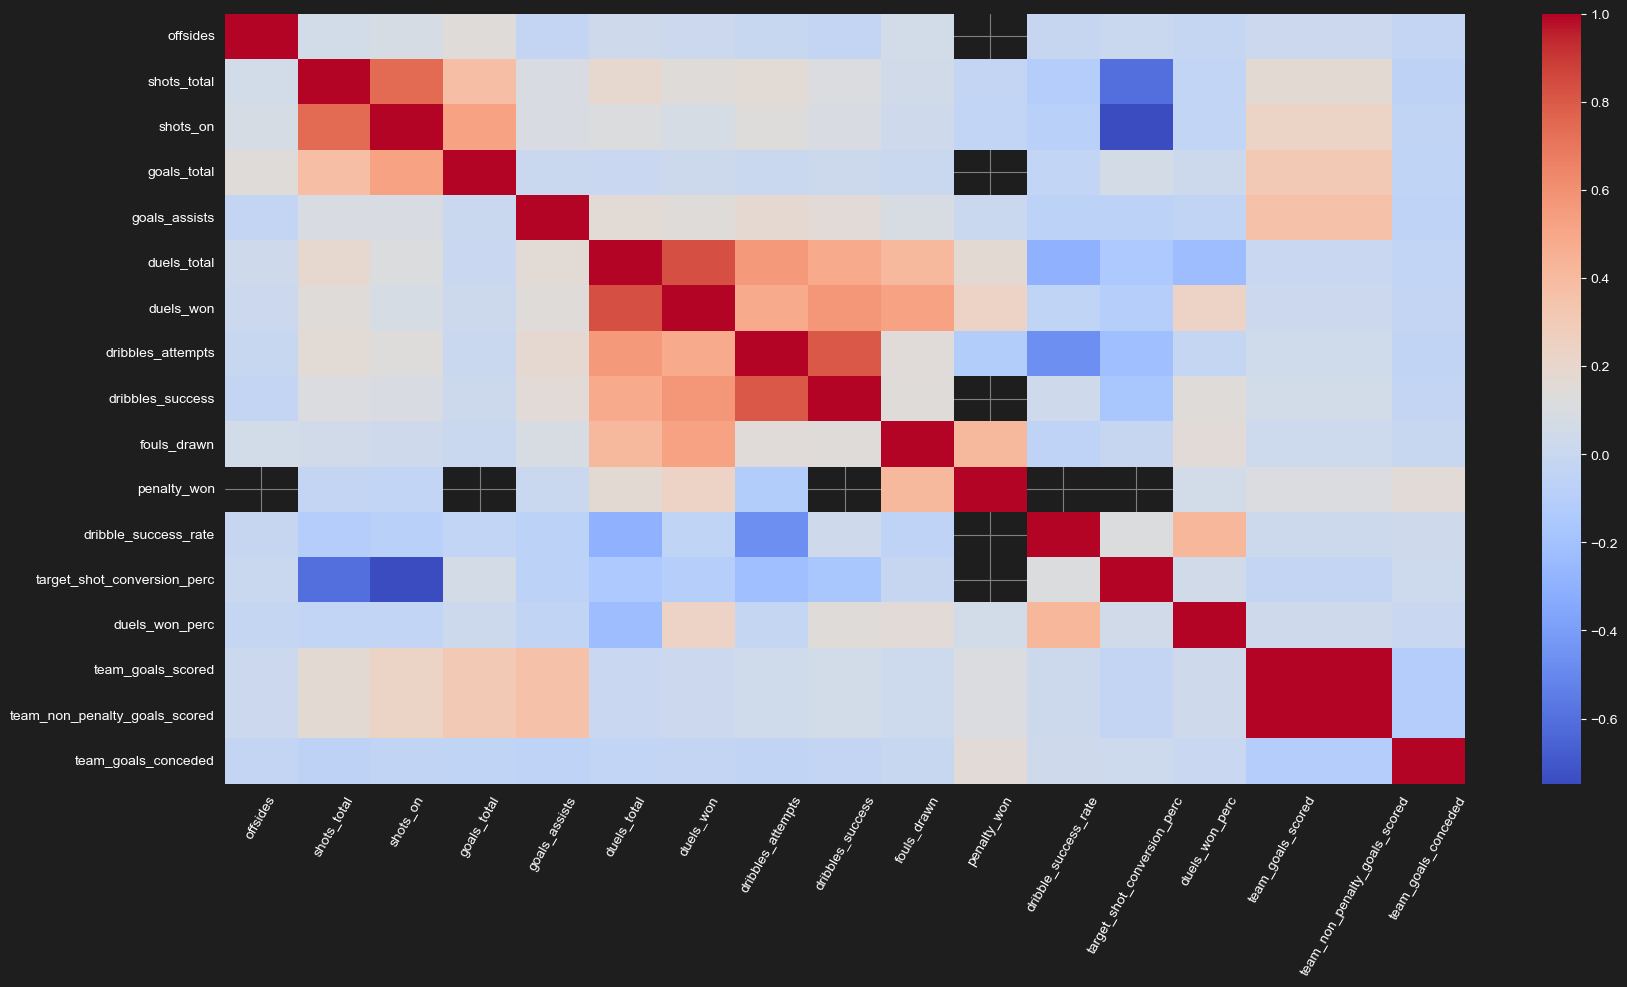

In [109]:
fig = plt.subplots(nrows=1, ncols = 1, figsize = (20,10))
fig = sns.heatmap(complete_data.query(filter_query)[config['ATTACK_COLS'] + ['team_goals_scored','team_non_penalty_goals_scored','team_goals_conceded']].corr(),cmap = 'coolwarm')
fig.set_xticklabels(fig.get_xticklabels(),rotation = 60)


In [ ]:
# trial multiclass model:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(complete_data[list(set(config['DEFENSE_COLS'] + config['PASSING_COLS'] + config['ATTACK_COLS'])) + ['outcome_num']].drop(columns = 'outcome_num'),complete_data[list(set(config['DEFENSE_COLS'] + config['PASSING_COLS'] + config['ATTACK_COLS'])) + ['outcome_num']][['outcome_num']],stratify=nn_dat[['outcome_num']],random_state=33)


In [207]:
dat = NNDataFromPd(X_train.fillna(0), y_train.outcome_num, dat_dict)
train_loader = DataLoader(dat, batch_size = 128,shuffle= True)

number of rows with Nulls: 25389    0
5892     0
15540    0
23087    0
22253    0
        ..
12129    0
23320    0
15712    0
18594    0
6316     0
Length: 19886, dtype: int64


In [242]:
train_loader.dataset.X_numeric_tensor.shape

torch.Size([19886, 27])

In [245]:
# model params
n_features = X_train.shape[1]
n_classes = y_train.iloc[:,0].nunique()
model = MultiClassModel(n_features,n_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)

In [246]:
epochs = 500

for epoch in range(epochs):
    
    epoch_loss = 0

    for X_numeric_batch, X_categoric_batch, y_batch in train_loader:
        
        pred = model.forward(X_numeric_batch)
        
        loss = criterion(pred,y_batch)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch: {epoch}, Loss: {epoch_loss}")

Epoch: 0, Loss: 174.2702145576477
Epoch: 1, Loss: 162.15641844272614
Epoch: 2, Loss: 160.41159814596176
Epoch: 3, Loss: 159.69596749544144
Epoch: 4, Loss: 159.66196352243423
Epoch: 5, Loss: 159.50144463777542
Epoch: 6, Loss: 159.36914026737213
Epoch: 7, Loss: 159.6879495382309
Epoch: 8, Loss: 159.59680008888245
Epoch: 9, Loss: 159.4443118572235
Epoch: 10, Loss: 159.353265106678
Epoch: 11, Loss: 159.40670466423035
Epoch: 12, Loss: 159.49340212345123
Epoch: 13, Loss: 159.33771032094955
Epoch: 14, Loss: 159.43414306640625
Epoch: 15, Loss: 159.35659617185593
Epoch: 16, Loss: 159.45236098766327
Epoch: 17, Loss: 159.42069256305695
Epoch: 18, Loss: 159.45192927122116
Epoch: 19, Loss: 159.32593953609467
Epoch: 20, Loss: 159.41840213537216
Epoch: 21, Loss: 159.35217851400375
Epoch: 22, Loss: 159.47601014375687
Epoch: 23, Loss: 159.43243342638016
Epoch: 24, Loss: 159.49224138259888
Epoch: 25, Loss: 159.21134096384048
Epoch: 26, Loss: 159.31141304969788
Epoch: 27, Loss: 159.26944082975388
Epoch: 

In [212]:
model.eval()

MultiClassModel(
  (bn): BatchNorm1d(27, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=27, out_features=3, bias=True)
)

In [215]:
X_test['passes_accuracy'] = X_test['passes_accuracy'].astype("float64")

In [227]:
# test sets

test_dat = NNDataFromPd(X_test,y_test,dat_dict)
test_loader = DataLoader(test_dat,batch_size= X_test.shape[0],shuffle=True)

number of rows with Nulls: 11475    12
24266    24
9617      9
15837    17
16680    11
         ..
14595    19
14301    12
7538     13
13095    24
4170     14
Length: 6629, dtype: int64


In [228]:
model.eval()
with torch.no_grad():
    for X_numeric_batch, X_categoric_batch, y_batch in test_loader:
        output = model(X_numeric_batch)
        pred_class = torch.argmax(output, dim = 1)

In [236]:
from validations import *

discrete_evaluations(y_test.values, pred_class)

Precision: 0.31213497212709596
Recall: 0.300196108010258
F1: 0.16853678131818442


/opt/miniconda3/envs/dlcpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


InvalidParameterError: The 'y_score' parameter of roc_auc_score must be an array-like. Got None instead.

In [273]:
# Logistic Model:
X_train, X_test, y_train, y_test = train_test_split(complete_data[list(set(config['DEFENSE_COLS'] + config['PASSING_COLS'] + config['ATTACK_COLS'])) + ['win']].drop(columns = 'win'),complete_data['win'],stratify=complete_data['win'],random_state=33)

In [309]:
train_dat = NNDataFromPd(X_train,y_train,dat_dict)

number of rows with Nulls: 25388     7
5892     12
8148     13
23086    24
6303     24
         ..
12129    11
2040     17
5936     20
25067    11
23874    12
Length: 19886, dtype: int64


In [310]:
train_loader = DataLoader(train_dat,batch_size= 128,shuffle = True)

In [ ]:
n_features = X_train.shape[1]
model = LogisticNNModelComplex(n_features)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.01)

In [314]:
epochs = 500
for epoch in range(epochs):
    epoch_loss = 0
    
    for X_numeric, X_categoric, y in train_loader:

        pred = model(X_numeric)

        loss = criterion(pred,y.unsqueeze(1))

        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch},  Loss: {loss}")


Epoch 0,  Loss: 0.6574453115463257
Epoch 1,  Loss: 0.6974596977233887
Epoch 2,  Loss: 0.6569901704788208
Epoch 3,  Loss: 0.6895307302474976
Epoch 4,  Loss: 0.6438461542129517
Epoch 5,  Loss: 0.6634082198143005
Epoch 6,  Loss: 0.6928731203079224
Epoch 7,  Loss: 0.7016840577125549
Epoch 8,  Loss: 0.7027255892753601
Epoch 9,  Loss: 0.6618971824645996
Epoch 10,  Loss: 0.6563957929611206
Epoch 11,  Loss: 0.717184841632843
Epoch 12,  Loss: 0.7144598960876465
Epoch 13,  Loss: 0.6837258338928223
Epoch 14,  Loss: 0.6841901540756226
Epoch 15,  Loss: 0.6654201149940491
Epoch 16,  Loss: 0.6623924970626831
Epoch 17,  Loss: 0.681372344493866
Epoch 18,  Loss: 0.7058840990066528
Epoch 19,  Loss: 0.7244184613227844
Epoch 20,  Loss: 0.7085081934928894
Epoch 21,  Loss: 0.6664770245552063
Epoch 22,  Loss: 0.6169545650482178
Epoch 23,  Loss: 0.6792559623718262
Epoch 24,  Loss: 0.6636468768119812
Epoch 25,  Loss: 0.6941231489181519
Epoch 26,  Loss: 0.7149714827537537
Epoch 27,  Loss: 0.7116495370864868
Epoc